<a href="https://colab.research.google.com/github/9terry-student/pytorch/blob/main/Multi_Head_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 랜덤 토큰 예제
tokens=["I","went","to","the","hospital"]
S=len(tokens)   # sequence length
D=8             # embedding dimension
B=1             # batch size
H=2             # head 개수

class MultiHeadAttention(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    assert embed_dim%num_heads==0, "D는 head 수로 나누어 떨어져야 함"
    self.embed_dim=embed_dim
    self.num_heads=num_heads
    self.head_dim=embed_dim//num_heads

    # Q,K,V를 전체 D에서 한 번에 만들기
    self.query=nn.Linear(embed_dim,embed_dim)
    self.key=nn.Linear(embed_dim,embed_dim)
    self.value=nn.Linear(embed_dim,embed_dim)

    self.out=nn.Linear(embed_dim,embed_dim)

  def forward(self,x):
    B,S,D=x.shape

    # Q,K,V shape: (B,S,D)
    Q=self.query(x)
    K=self.key(x)
    V=self.value(x)

    # Multi-Head로 나누기: (B,head,S,head_dim)
    Q=Q.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    K=K.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    V=V.view(B,S,self.num_heads,self.head_dim).transpose(1,2)

    # Attention 계산
    scores=torch.matmul(Q,K.transpose(-2,-1))/(self.head_dim**0.5)
    weights=F.softmax(scores,dim=-1)
    out=torch.matmul(weights,V)   # (B,head,S,head_dim)

    # 다시 합치기
    out=out.transpose(1,2).contiguous().view(B,S,D)
    out=self.out(out)
    return out,weights

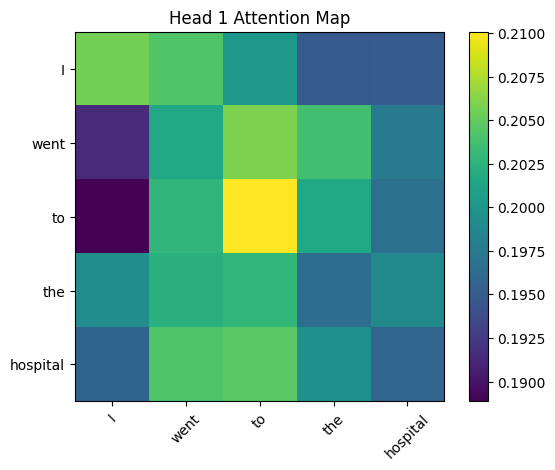

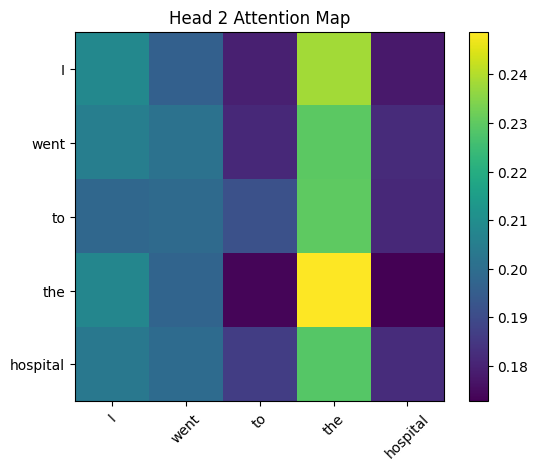

In [5]:
# 시각화

# 입력 벡터 (랜덤)
x=torch.rand(B,S,D)

mha=MultiHeadAttention(D,H)
mha_out,weights=mha(x)

# Residual 연결 + LayerNorm
x=x+mha_out
x=nn.LayerNorm(D)(x)

# head별 히트맵
for h in range(H):
  attn=weights[0,h].detach().numpy()    # (S,S)
  plt.figure()
  plt.imshow(attn)
  plt.xticks(range(S),tokens,rotation=45)
  plt.yticks(range(S),tokens)
  plt.colorbar()
  plt.title(f"Head {h+1} Attention Map")
  plt.show()